# Отчет о выполненном проекте

## цели и задачи проекта, описание исходных и обработанных данных и признаков

В этом проекте мы будем решать задачу идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии.

По последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

Конечной целью проекта является разработка модели, эффективность которой в соревновании будет выше, чем в бенчмарках.

Данные собраны с прокси-серверов Университета Блеза Паскаля и имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user****.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате:

В соревновании представлена выборка, образованная на основе обработанных данных. В обучающей выборке train_sessions.csv:

1. Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
2. Признаки time_j – время посещения сайтов site_j
3. Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

В каждой сессии содержится информация о максимум 10 посещенных сайтах.

## Первичный анализ признаков. Первичный визуальный анализ признаков

На этапе первичного анализа исследовались "сырые" данные. Было сформировано несколько выборок, содержащих сессии 10 и 150 пользователей. В каждой сессии было отмечено до 10 сайтов, которые посещали пользователи, а также время их посещения. Получились признаки вида site1, ..., site10 и time1, ..., time10, аналогичные признакам обучающей выборки соревнования.

Выборка из 10 пользователей содержит 14061 уникальных сессий, в которых посещалось 4913 уникальных сайтов.

Выборка из 150 пользователей содержит 137019 уникальных сессий, в которых посещалось 27797 уникальных сайтов.

Среди 150 пользователей самыми популярными оказались следующие сайты:

1. www.google.fr
2. www.google.com
3. www.facebook.com
4. apis.google.com
5. s.youtube.com
6. clients1.google.com
7. mail.google.com
8. plus.google.com
9. safebrowsing-cache.google.com
10. www.youtube.com

Если так подумать, то полученные признаки site1, ..., site10* смысла не имеют как признаки в задаче классификации. А вот если воспользоваться идеей мешка слов из анализа текстов – это другое дело. Создадим новые матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки i и столбца j будет стоять число nij – cколько раз сайт j встретился в сессии номер i. Делать это будем с помощью разреженных матриц Scipy – csr_matrix.**

Перед визуальным анализом были вычислены и добавлены новые признаки:

* Время сессиии
* Кол-во уникальных сайтов в сессии
* Время переключения между сайтами
* Час начала
* День недели

Эти признаки исследовались на небольшой выборке, содержащей сессии 10 пользователей. Целью исследования было конструирование и выявление признаков, потенциально полезных при решении задачи классификации. Для этого исследовались паттерны поведения пользователей: сколько сайтов они посещают за сессию, как долго, какие это сайты, сколько в среднем пользователь тратит на посещение сайтов и т.д.

In [ ]:
#импорт необходимых модулей
import warnings
import math
warnings.filterwarnings('ignore')
from glob import glob
import os
import itertools
import pickle
from tqdm import tqdm_notebook, tqdm
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC

from sklearn.model_selection import learning_curve

In [ ]:
# подключение google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# путь к данным
PATH_TO_DATA = 'drive/MyDrive/Colab_data/capstone_user_identification_data'

In [ ]:
# исходные данные
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, '10users/user0031.csv'))
user31_data.head(3)

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net


In [ ]:
#вспомогательные функции

# 1. реализация bootstrap
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# 2. отрисовка кривых валидации
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()
    
# 3. кривая обучения
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [ ]:
def prepare_train_set(path_to_csv_files, session_length=10):

    site_freq_dict = {}
    sessions_df = pd.DataFrame()
    csv_files_list = [f for f in os.listdir(path_to_csv_files) 
                      if os.path.isfile(os.path.join(path_to_csv_files, f)) and f.endswith('.csv')]
    
    global_session = 0
    for csv in tqdm(sorted(csv_files_list)):
        df = pd.read_csv(os.path.join(path_to_csv_files, csv), parse_dates=['timestamp'])
        df['user_id'] = int(csv.replace('.csv', '').replace('user', ''))
        df['session_id'] = 0
        df['site_num'] = 0
        
        for user_session in range(math.ceil(len(df)/session_length)):
            global_session += 1
            session_slice = slice(user_session*session_length, (user_session+1)*session_length)
            update_indices = df.index[session_slice].values
            df.loc[update_indices, 'session_id'] = global_session
            df.loc[update_indices, 'site_num'] = range(1, len(update_indices)+1)

        sessions_df = sessions_df.append(df, ignore_index=True)
        counts = df.site.value_counts()
        for site, freq in zip(counts.index, counts.values):
            if site_freq_dict.get(site, None):
                site_freq_dict[site] += freq
            else:
                site_freq_dict[site] = freq
        
    site_freq_dict = {x[0][0]: (x[1], x[0][1]) 
                      for x in zip(sorted(site_freq_dict.items(), key=lambda x: x[1], reverse=True),
                                   range(1, len(site_freq_dict) + 1))}
    
    sessions_df.site = sessions_df.site.apply(lambda x: site_freq_dict[x][0])

    
    sessions_pivot = sessions_df.pivot_table(values=['site'], index='session_id',
                                 columns=['site_num'], fill_value=0).add_prefix('site').reset_index()
        
    sessions_pivot.columns = [x[1] for x in sessions_pivot.columns]
    sessions_pivot.rename(columns={'':'session_id'}, inplace=True)
    sessions_pivot = pd.merge(sessions_pivot, sessions_df[['session_id', 'user_id']].drop_duplicates(), left_on='session_id', 
                              right_on='session_id', how='left')
    sessions_pivot.set_index('session_id', inplace=True)
    
    return sessions_pivot, site_freq_dict


def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    site_freq = {}
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)

    indptr = [0]
    indices = []
    data = []
    userids = []
    
    sessions_df = pd.DataFrame()
    csv_files_list = [f for f in os.listdir(path_to_csv_files) 
                      if os.path.isfile(os.path.join(path_to_csv_files, f)) and f.endswith('.csv')]
    
    for csv in sorted(csv_files_list):
        userid = int(csv.replace('.csv', '').replace('user', ''))
        df = pd.read_csv(os.path.join(path_to_csv_files, csv), parse_dates=['timestamp'])
        siteids = df['site'].apply(lambda x: site_freq[x][0]).tolist()
        
        for user_session_idx in range(ceil(len(df)/window_size)):
            session = siteids[user_session_idx * window_size: user_session_idx * window_size + session_length]

            for siteid in session:
                indices.append(siteid - 1)
                data.append(1)
            indptr.append(len(indices))
            userids.append(userid)
            
        
    return csr_matrix((data, indices, indptr), dtype=int), userids 

In [ ]:
# Проверим работу функции на маленьком наборе данных
train_data_toy, site_freq_3users = prepare_train_set(os.path.join(PATH_TO_DATA, '3users'), session_length=10)
train_data_toy

100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
1,3,2,2,8,2,1,9,5,7,10,1
2,3,1,1,1,0,0,0,0,0,0,1
3,3,2,6,6,2,0,0,0,0,0,2
4,4,1,2,1,2,1,1,5,11,4,3
5,4,1,2,0,0,0,0,0,0,0,3


In [ ]:
%%time
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, '10users'), session_length=10)
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, '150users'), session_length=10)

100%|██████████| 150/150 [02:39<00:00,  1.07s/it]


CPU times: user 2min 53s, sys: 1.34 s, total: 2min 54s
Wall time: 2min 57s


Применим полученную функцию на наборы из 10 и 150 пользователей

In [ ]:
train_data_10users.to_csv(os.path.join(PATH_TO_DATA, 
                                       'train_data_10users.csv'), 
                        index_label='session_id', float_format='%d')
train_data_150users.to_csv(os.path.join(PATH_TO_DATA, 
                                        'train_data_150users.csv'), 
                         index_label='session_id', float_format='%d')

Для дальнейшего анализа запишем полученные объекты DataFrame в csv-файлы.

In [ ]:
def prepare_sparse_matrix(dense_matrix):
    indexes, vals = [], []
    indptr = [0]
    vocab = {}
    for row in dense_matrix:
        for col in row:
            if col != 0:
                indexes.append(vocab.setdefault(col, col))
                vals.append(1)
        indptr.append(len(indexes))
    return csr_matrix((vals, indexes, indptr), dtype=int)[:, :-1]

In [ ]:
def prepare_sparse_matrix_toy(dense_matrix):
    indexes, vals = [], []
    indptr = [0]
    vocab = {}
    for row in dense_matrix:
        for col in row:
            if col != 0:
                indexes.append(vocab.setdefault(col, col))
                vals.append(1)
        indptr.append(len(indexes))
    return csr_matrix((vals, indexes, indptr), dtype=int)[:, 1:]

In [ ]:
# Применим функцию для наборов из 10 и 150 пользователей
X_3users, y_3users = train_data_toy.iloc[:, 1:].values, train_data_toy.iloc[:, 1].values
X_10users, y_10users = train_data_10users.iloc[:, :-1].values, train_data_10users.iloc[:, -1].values
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, train_data_150users.iloc[:, -1].values

In [ ]:
X_sparse_3users = prepare_sparse_matrix_toy(X_3users)
X_sparse_10users = prepare_sparse_matrix(X_10users)
X_sparse_150users = prepare_sparse_matrix(X_150users)

In [ ]:
# Получили разреженные матрицы. Убедимся, что количество признаков в этих матрицах равно длине частотных словарей
print(X_sparse_3users.shape[1] == len(site_freq_3users))
print(X_sparse_10users.shape[1] == len(site_freq_10users))
print(X_sparse_150users.shape[1] == len(site_freq_150users))

True
True
True


In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_10users.pkl'), 'wb') as X10_pkl:
    pickle.dump(X_sparse_10users, X10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'wb') as y10_pkl:
    pickle.dump(y_10users, y10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_150users.pkl'), 'wb') as X150_pkl:
    pickle.dump(X_sparse_150users, X150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'y_150users.pkl'), 'wb') as y150_pkl:
    pickle.dump(y_150users, y150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_3users.pkl'), 'wb') as site_freq_3users_pkl:
    pickle.dump(site_freq_3users, site_freq_3users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_10users.pkl'), 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

In [ ]:
sessions, sit_freq_dict = prepare_train_set(os.path.join(PATH_TO_DATA, '10users'))

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


In [ ]:
#содержимое сессий
sessions.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
1,193,575,133,3,133,133,3,133,203,133,31
2,415,192,675,255,133,31,393,3573,217,55,31
3,55,3,55,55,5,293,415,333,900,55,31
4,473,3664,473,55,55,55,55,944,199,123,31
5,342,55,5,3618,258,211,3540,2106,674,2106,31


In [ ]:
#Распределение целевого класса:
sessions.user_id.value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

In [ ]:
#Распределение числа уникальных сайтов в каждой сессии
num_unique_sites = [np.unique(sessions.values[i, :-1]).shape[0] 
                    for i in range(sessions.shape[0])]
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

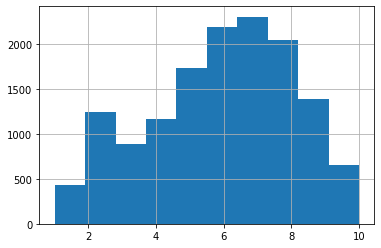

In [ ]:
ax = pd.Series(num_unique_sites).hist()

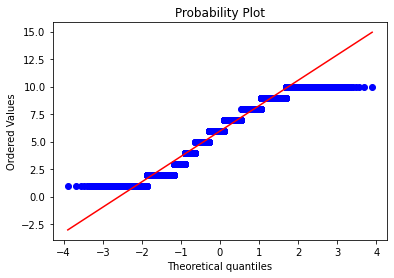

In [ ]:
#Оценка распределения числа уникальных сайтов в сессии из 10 сайтов
stats.probplot(num_unique_sites, dist="norm", plot=plt);

In [ ]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %e" % stats.shapiro(num_unique_sites))

Shapiro-Wilk normality test, W-statistic: 0.954693, p-value: 0.000000e+00


Вывод: Распределение количества уникальных сайтов не является нормальным

In [ ]:
#Гипотеза о повторном посещении сайта в рамках одной сессии
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
pi_val = stats.binom_test([sum(has_two_similar), len(has_two_similar) - sum(has_two_similar)], p=0.95, alternative='greater')

pi_val

0.02207653769072678

In [ ]:
wilson_interval = proportion_confint(sum(has_two_similar), len(has_two_similar), method = 'wilson')
wilson_interval

(0.9501028841411286, 0.9570527377232229)

Вывод: Гипотеза о доле повторных сайтов в сессии меньше 0.95 отвергается на уровне значимости 0.022. Доверительный 95% интервал [0.9501, 0.9571]

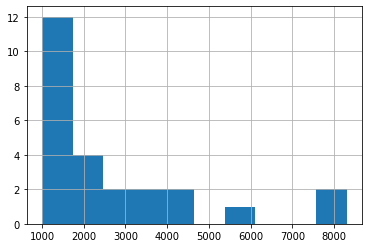

In [ ]:
#Распределение частоты посещения популярных сайтов
site_freqs = pd.Series(sessions.values[:, :-1].flatten()).value_counts()
ax = site_freqs[site_freqs>=1000].hist()

In [ ]:
n_samples = len(site_freqs)
site_freqs.drop(index=0).tolist()
samples = get_bootstrap_samples(site_freqs.drop(index=0).to_numpy(), n_samples)
stat_intervals(np.mean(samples, axis=1), 0.05)

array([22.51531142, 35.76286383])

95% доверительный интервал для средней частоты появления сайта в выборке [22.52, 35.76]

Поиск дополнительных признаков
Дополнительно к id сайтов в качестве признаков сессии добавляются следующие параметры:

* session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
* #unique_sites – число уникальных сайтов в сессии
* start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
* day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

Реализуем соответствующую функцию

In [ ]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    site_freq = {}
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)

    matrix = []
    
    csv_files_list = [f for f in os.listdir(path_to_csv_files) 
                      if os.path.isfile(os.path.join(path_to_csv_files, f)) and f.endswith('.csv')]
    
    for csv in sorted(csv_files_list):
        userid = int(csv.replace('.csv', '').replace('user', ''))
        df = pd.read_csv(os.path.join(path_to_csv_files, csv), parse_dates=['timestamp'])  
        
        siteids = df['site'].apply(lambda x: site_freq[x][0]).to_numpy()
        sitetss = pd.to_datetime(df['timestamp'], unit='s').tolist()

        
        for user_session_idx in range(math.ceil(len(df)/window_size)):
            slice_ = slice(user_session_idx * window_size, user_session_idx * window_size + session_length)
        
            session = siteids[slice_].tolist() + [0] * (session_length - len(siteids[slice_]))
            ts = sitetss[slice_]
            
            row = session + list(map(lambda x: x.seconds, np.diff(ts).tolist())) + \
                  [0] * (session_length - len(siteids[slice_])) +\
                  [(ts[-1] - ts[0]).seconds]  + \
                  [len(set(session))] + [ts[0].hour] + [ts[0].weekday()] + [userid]
            matrix.append(row)
            
      
    sessions_df = pd.DataFrame(matrix, columns=feature_names)
        
    return sessions_df

In [ ]:
#проверка работоспособности на 3-х пользователях
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                                            site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                                            feature_names=feature_names, session_length=10)

train_data_toy.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,8,2,1,9,5,7,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,3,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,4,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,4,12,4,3


In [ ]:
#проверка работоспособности на 10-х пользователях
train_data_10users_fith_fe  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                            site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                            feature_names=feature_names, session_length=10)

In [ ]:
train_data_10users_fith_fe['target'].unique()

array([ 31,  33,  39,  50, 100, 127, 128, 207, 237, 241])

In [ ]:
#проверка работоспособности на 150-х пользователях
train_data_150users_fith_fe  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                                            site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                            feature_names=feature_names, session_length=10)

In [ ]:
train_data_150users_fith_fe['target'].unique()

array([   6,   13,   15,   16,   28,   31,   33,   39,   46,   49,   50,
         53,   65,   66,   82,   85,   89,   92,  100,  102,  103,  105,
        106,  118,  119,  120,  126,  127,  128,  138,  158,  160,  165,
        172,  177,  203,  207,  223,  233,  235,  236,  237,  238,  240,
        241,  242,  245,  246,  249,  252,  254,  256,  258,  259,  260,
        261,  263,  264,  269,  270,  273,  287,  294,  298,  301,  308,
        315,  318,  327,  332,  333,  339,  340,  342,  344,  351,  356,
        361,  363,  411,  417,  425,  430,  435,  436,  440,  444,  475,
        476,  486,  515,  533,  561,  563,  564,  568,  569,  570,  573,
        575,  576,  580,  583,  584,  600,  603,  605,  640,  647,  653,
        664,  665,  677,  692,  697,  705,  722,  740,  741,  756,  780,
        784,  785,  797,  812,  844,  859,  868,  875,  932,  996, 1014,
       1040, 1054, 1248, 1267, 1299, 1371, 1797, 1798, 1993, 2118, 2174,
       2191, 2250, 2355, 2408, 2493, 2625, 2902])

Визуальный анализ признаков

Для визуализации и удобства различия пользователей зададим пользователям имена и цвета

In [ ]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [ ]:
#загрузим логи 10 пользователей
sessions_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'),
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                               feature_names=feature_names, session_length=10)

In [ ]:
sessions_10users['target'] = sessions_10users['target'].map(id_name_dict)

Гистограма распределения длины сессии

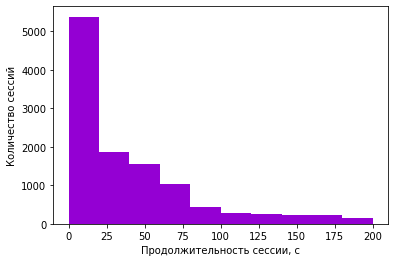

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Продолжительность сессии, с')
ax.set_ylabel('Количество сессий')
plt.hist(sessions_10users['session_timespan'], color='darkviolet', range=(0, 200))

plt.show()

Гистограмма распределения числа уникальных сайтов в сессиии

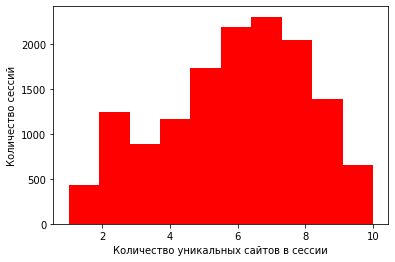

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Количество уникальных сайтов в сессии')
ax.set_ylabel('Количество сессий')
plt.hist(sessions_10users['#unique_sites'], color='red')

plt.show()

Гистограмма распределения числа уникальных сайтов в сессиии для каждого из пользователей

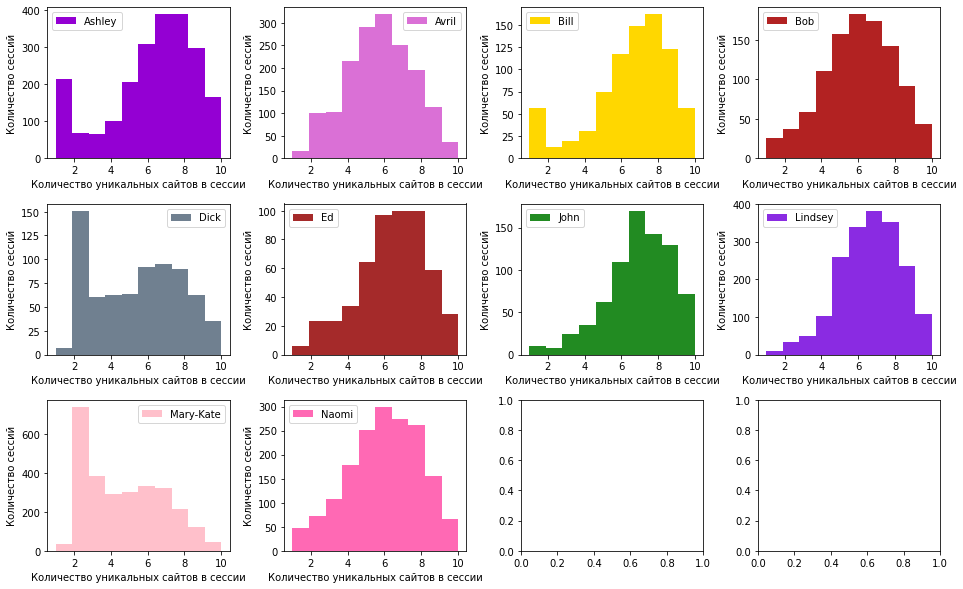

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(sessions_10users, 'target')):
    axis = axes[idx//4, idx % 4]
    axis.hist(sub_df['#unique_sites'], color=color_dic[user], label=user)
    axis.legend()
    axis.set_xlabel('Количество уникальных сайтов в сессии')
    axis.set_ylabel('Количество сессий')

Гистограмма распределения часа начала сессии

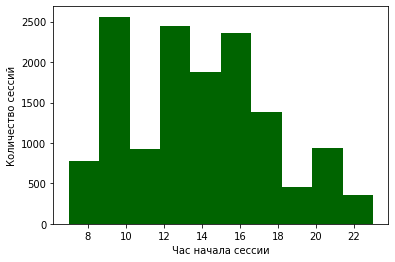

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Час начала сессии')
ax.set_ylabel('Количество сессий')
plt.hist(sessions_10users['start_hour'], color='darkgreen')

plt.show()

Гистограмма распределения часа начала сессии для каждого из пользователей

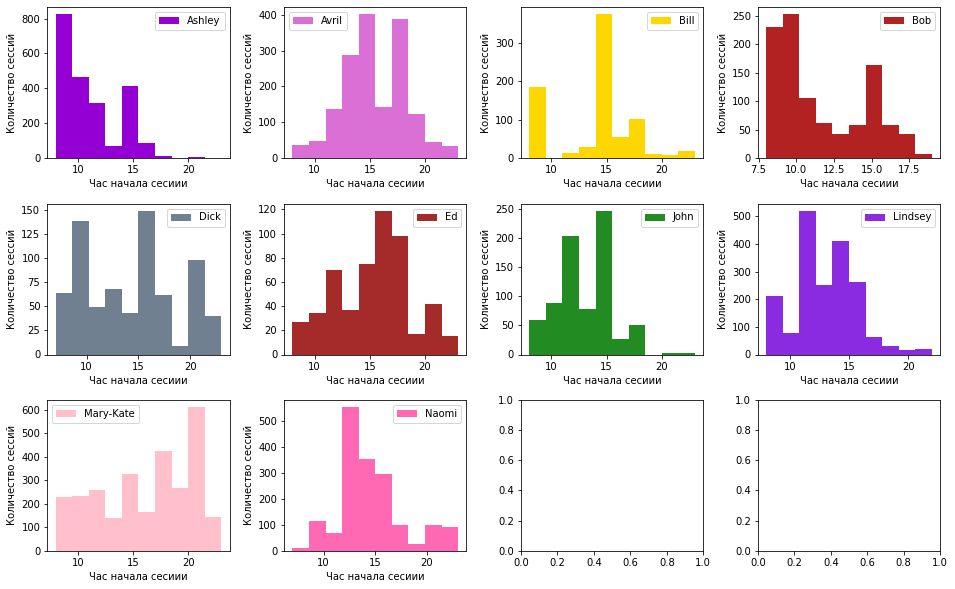

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(sessions_10users, 'target')):
    axis = axes[idx//4, idx % 4]
    axis.hist(sub_df['start_hour'], color=color_dic[user], label=user)
    axis.legend()
    axis.set_xlabel('Час начала сесиии')
    axis.set_ylabel('Количество сессий')

Гистограмма распределения дня недели, в который началась сессия

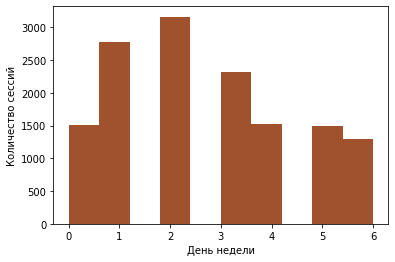

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('День недели')
ax.set_ylabel('Количество сессий')
plt.hist(sessions_10users['day_of_week'], color='sienna')

plt.show()

Гистограмма распределения дня недели, в который началась сессия для каждого пользователя

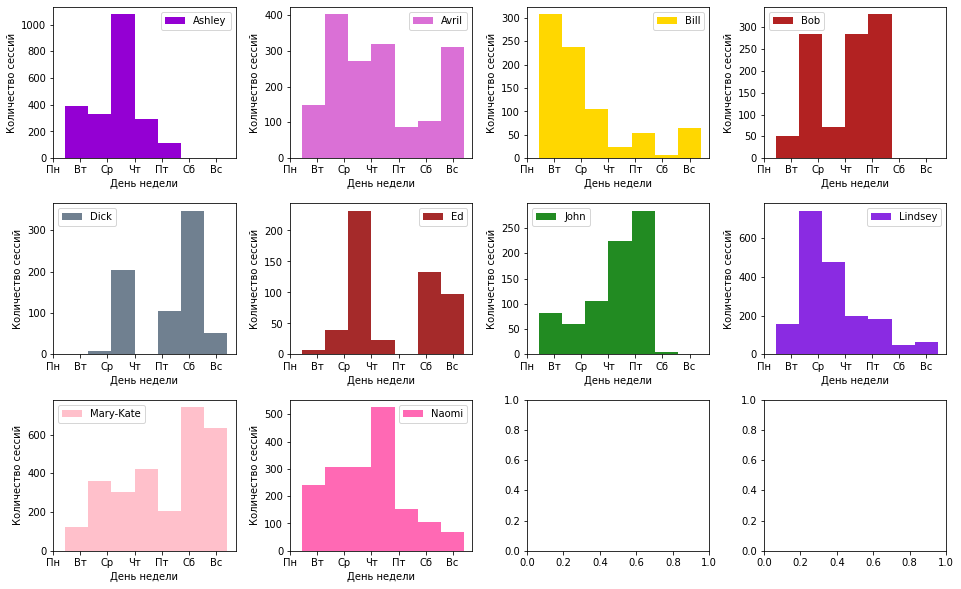

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(sessions_10users, 'target')):
    axis = axes[idx//4, idx % 4]
    axis.hist(sub_df['day_of_week'], color=color_dic[user], label=user, range=(0,6), bins=7, align='right')
    axis.legend()
    axis.set_xlabel('День недели')
    axis.set_xticks(range(7))
    axis.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axis.set_ylabel('Количество сессий')

Вывод по дополнительным признакам
Анализ распределений количества сессий в зависимости от количества уникальных сайтов в сессии не позволяет в достаточной степени различить пользователей. У многих пользователей распределения близки (визуально)

Распределения количества сессий в зависимости от часа начала более значительно различаются от пользователя к пользователям и могут содержать полезную информацию при классификации пользователей.

Распределения количества сессий в зависимости от дня недели также значительно различаются от пользователя к пользователям и могут содержать полезную информацию при классификации пользователей.

Пользователь Ashley большую часть сессий устанавливает в утреннее время, в первой половине недели, чаще всего количество сайтов в сессии составляет от 6 до 8.

Пользователь Avril большую часть сессий устанавливает в послеобеденное время и раннее вечернее, наибошая активность со вторника по пятницу и в воскресенье. Чаще всего количество сайтов в сессии составляет 6.

Пользователь John организовывает большую часть сессий до 15:00, в рабочие дни недели с пиком в пятницу. чаще всего количество сайтов в сессии составляет от 6 до 8.

Оценка распределения топ-10 сайтов

In [ ]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
        site_freq = pickle.load(f)

top10items = sorted(site_freq.items(), key=lambda x: x[1][1], reverse=True)[:10]

top10_freqs = [item[1][1] for item in top10items]
top10_sites = [item[0] for item in top10items]

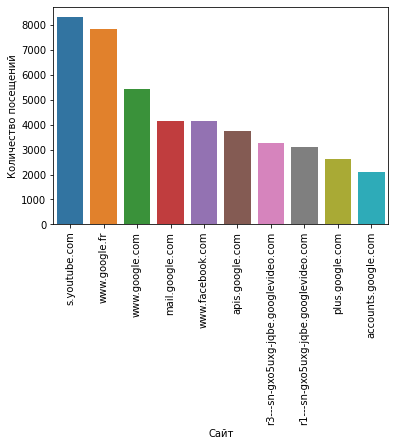

In [ ]:
chart = sns.barplot(top10_sites, top10_freqs)
chart.set_xlabel('Сайт')
chart.set_ylabel('Количество посещений')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

Кроссвалидация, построение кривых валидации и обучения

Сравнение нескольких алгоритмов классификации на сессиях из 10 сайтов

In [ ]:
#Загрузка объектов
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

In [ ]:
X_sparse_10users.shape, y_10users.shape

((14061, 4913), (14061,))

In [ ]:
#Разделение выборки на обучающую и тестовую
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                      random_state=17, stratify=y_10users)

In [ ]:
#Создаем объект кроссвалидации (3 фолда, с перемешиванием, стратифицированная)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

1. Алгоритм K ближайших соседей

In [ ]:
%%time
knn = KNeighborsClassifier(n_neighbors=100)
scores = cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1)
print(f'Средняя оценка accuracy на кроссвалидации: {np.mean(scores)}')

knn.fit(X_train, y_train)
print(f'Средняя оценка accuracy на тестовой выборке: {accuracy_score(knn.predict(X_valid), y_valid)}')

Средняя оценка accuracy на кроссвалидации: 0.5595405797855602
Средняя оценка accuracy на тестовой выборке: 0.5837876273998578


2. Случайный лес из 100 деревьев

In [ ]:
%%time
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)

scores = cross_val_score(forest, X_train, y_train, cv=skf, n_jobs=-1)
print(f'Средняя оценка accuracy на кроссвалидации: {np.mean(scores)}')

forest.fit(X_train, y_train)
print(f'Средняя оценка accuracy на тестовой выборке: {accuracy_score(forest.predict(X_valid), y_valid)}')

Средняя оценка accuracy на кроссвалидации: 0.7157087307310136
Средняя оценка accuracy на тестовой выборке: 0.733349134866082
CPU times: user 21.9 s, sys: 90.7 ms, total: 22 s
Wall time: 33.8 s


3. Логистическая регрессия

In [ ]:
%%time
logit = LogisticRegression(random_state=17, n_jobs=1)
scores = cross_val_score(logit, X_train, y_train, cv=skf, n_jobs=-1)
print(f'Средняя оценка accuracy на кроссвалидации: {np.mean(scores)}')

logit.fit(X_train, y_train)
print(f'Средняя оценка accuracy на тестовой выборке: {accuracy_score(logit.predict(X_valid), y_valid)}')

Средняя оценка accuracy на кроссвалидации: 0.7605173789470293
Средняя оценка accuracy на тестовой выборке: 0.776250296278739
CPU times: user 3.05 s, sys: 3.83 s, total: 6.87 s
Wall time: 8.36 s


In [ ]:
%%time
#Поиск оптимального параметра С для логистической регрессии
logit_c_values1 = np.logspace(-4, 2, 10)
logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', n_jobs=-1, cv=skf)
logit_grid_searcher1.fit(X_train, y_train)

logit_cv_scores1 = np.array(list(logit_grid_searcher1.scores_.values()))
logit_mean_cv_scores1 = np.mean(logit_cv_scores1, axis=(0,1))

Text(0, 0.5, 'Mean CV score')

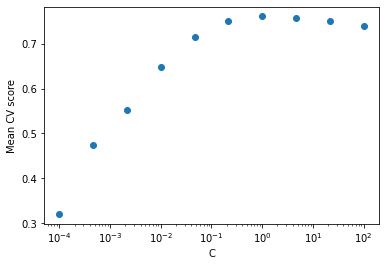

In [ ]:
plt.scatter(logit_c_values1, logit_mean_cv_scores1);
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('Mean CV score')

In [ ]:
%%time
#поиск из ограниченного интервала для параметра С
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', n_jobs=-1, cv=skf, refit=False)
logit_grid_searcher2.fit(X_train, y_train)

logit_cv_scores2 = np.array(list(logit_grid_searcher2.scores_.values()))
logit_mean_cv_scores2 = np.mean(logit_cv_scores2, axis=(0,1))

Text(0, 0.5, 'Mean CV score')

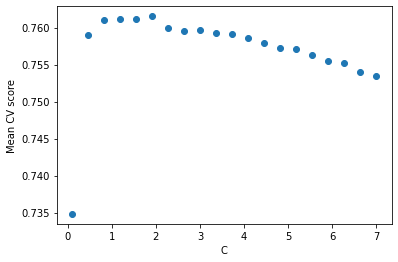

In [ ]:
plt.scatter(logit_c_values2, logit_mean_cv_scores2);
plt.xlabel('C')
plt.ylabel('Mean CV score')

In [ ]:
# Лучшее значение параметра С для логистической регрессии:
max(logit_mean_cv_scores2), logit_c_values2[np.argmax(logit_mean_cv_scores2)]

(0.7615335461873364, 1.9157894736842107)

In [ ]:
%%time
# Доля правильных ответов на тествовой выборке, полученная с помощью логистической регрессии с оптимальным значением параметра С
best_logit = LogisticRegression(C=1.9157894736842107, n_jobs=-1)
best_logit.fit(X_train, y_train)
logit_cv_acc = accuracy_score(best_logit.predict(X_valid), y_valid)
logit_cv_acc

CPU times: user 21 ms, sys: 2.11 ms, total: 23.1 ms
Wall time: 1.66 s


4. Классификатор на опорных векторах

In [ ]:
%%time
svm = LinearSVC(C=1, random_state=17)
scores = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)

print(f'Средняя оценка accuracy на кроссвалидации: {np.mean(scores)}')

Средняя оценка accuracy на кроссвалидации: 0.7506623501163388
CPU times: user 38.3 ms, sys: 4 ms, total: 42.3 ms
Wall time: 3.18 s


In [ ]:
%%time
# Поиск оптмального значения параметра С
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.46 s, sys: 54.9 ms, total: 3.51 s
Wall time: 42.3 s


In [ ]:
# Значение параметра С, дающее лучшую долю правильных ответов на кроссвалидации (на заданной сетке)
svm_grid_searcher1.best_params_, svm_grid_searcher1.best_score_ 

({'C': 4444.4445000000005}, 0.6888847899832244)

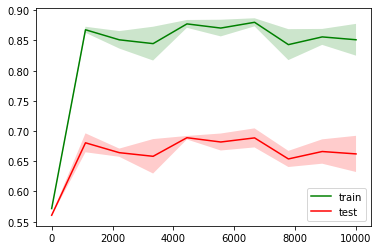

In [ ]:
# график зависимости доли правильных ответов на кросс-валидации от C
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

In [ ]:
%%time
# Поиск оптимального значения параметра в итервале близком к 1
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.55 s, sys: 86.6 ms, total: 1.64 s
Wall time: 1min 13s


In [ ]:
svm_grid_searcher2.best_params_, svm_grid_searcher2.best_score_

({'C': 0.10434482758620689}, 0.7670206386611259)

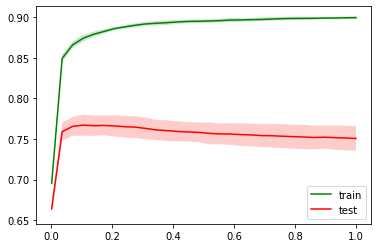

In [ ]:
# график зависимости доли правильных ответов на кросс-валидации от C
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

In [ ]:
# Доля правильных ответов на тествовой выборке, полученная с помощью классификатора на опорных векторах с 
# оптимальным значением параметра С

svm_best = LinearSVC(C=0.10434482758620689, random_state=17)
svm_best.fit(X_train, y_train)
svm_cv_acc = accuracy_score(svm_best.predict(X_valid), y_valid)
svm_cv_acc

0.7807537331121118

Лучшие значения доли правильных ответов при многоклассовой классификации показывает логистическая регрессия, для которой подобрано оптимальное значение параметра С.

Определение оптимальных значений параметров: длина сессии и ширина окна

In [ ]:
# Реализуем функцию, выполняющую оценку доли правильных ответов на классификации
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size, random_state=random_state, stratify=y)
    
    cv_scores = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    estimator.fit(X_train, y_train)
    valid_score = accuracy_score(estimator.predict(X_valid), y_valid)
    return cv_scores, valid_score

In [ ]:
%%time
# Используем модель, дающее лучшую долю правильных ответов на кроссвалидации

estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in tqdm(itertools.product([10, 7, 5], [15, 10, 7, 5])):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_10users_s{session_length}_w{window_size}.pkl')
        print(f's{session_length}_w{window_size}:', model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

1it [00:04,  4.26s/it]

s15_w10: (array([0.81840341, 0.81987199, 0.82962511]), 0.8464091016828632)


2it [00:06,  3.00s/it]

s10_w10: (array([0.75776965, 0.76196282, 0.76562024]), 0.7845461009717942)


5it [00:11,  1.98s/it]

s15_w7: (array([0.85001067, 0.84787711, 0.85638071]), 0.852165256346441)


6it [00:14,  2.25s/it]

s10_w7: (array([0.79645829, 0.79944527, 0.80409731]), 0.8065372490459598)


7it [00:15,  2.11s/it]

s7_w7: (array([0.75058673, 0.75186687, 0.74861289]), 0.7585863613738179)


9it [00:22,  2.63s/it]

s15_w5: (array([0.86863761, 0.86572169, 0.87273282]), 0.8763778594287069)


10it [00:26,  2.88s/it]

s10_w5: (array([0.81987199, 0.81237616, 0.81496723]), 0.8269527083086405)


11it [00:28,  2.74s/it]

s7_w5: (array([0.7685157 , 0.76573693, 0.77168115]), 0.7900912646675359)


12it [00:30,  2.52s/it]

s5_w5: (array([0.7253886 , 0.71559214, 0.72306051]), 0.7395993836671803)
CPU times: user 9.67 s, sys: 106 ms, total: 9.78 s
Wall time: 30.3 s


увеличение длины сессии и уменьшение ширины окна увеличивает долю правильных ответов.

Идентификация конкретного пользователя

In [ ]:
# Загрузим данные для 150 пользователей

with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [ ]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

In [ ]:
%%time
# Обучение 150 классификаторов типа "Один против всех"
logit_cv_150users = LogisticRegressionCV(Cs=[3.7315789473684213], multi_class='ovr', n_jobs=-1, cv=skf, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 6min 49s, sys: 7min 30s, total: 14min 20s
Wall time: 13min 48s


In [ ]:
# доля правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности

cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = np.mean(logit_cv_150users.scores_[user_id])
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))

User 6, CV score: 0.9960693545191998
User 13, CV score: 0.9963404335178755
User 15, CV score: 0.9952769697538395
User 16, CV score: 0.9917529427710529
User 28, CV score: 0.9903037127396703
User 31, CV score: 0.9942030798744695
User 33, CV score: 0.9937339046844537
User 39, CV score: 0.9858830398381867
User 46, CV score: 0.9979669075099308
User 49, CV score: 0.9953186742151742
User 50, CV score: 0.9942552104511381
User 53, CV score: 0.9936192174157831
User 65, CV score: 0.9968825915152273
User 66, CV score: 0.9947452378718213
User 82, CV score: 0.9963195812872083
User 85, CV score: 0.9963717118638766
User 89, CV score: 0.9906999051223505
User 92, CV score: 0.9943907499504759
User 100, CV score: 0.994422028296477
User 102, CV score: 0.9911482280816991
User 103, CV score: 0.9805969993640069
User 105, CV score: 0.9969347220918957
User 106, CV score: 0.9948390729098245
User 118, CV score: 0.9909605580056926
User 119, CV score: 0.9965802341705503
User 120, CV score: 0.9942969149124727
User 1

In [ ]:
# проверка качества по отношению к наивному классификатору
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    cv_score = cv_scores_by_user[user_id]
    const_score = 1 - class_distr[user_id]/len(y_train_150)
    acc_diff_vs_constant.append(cv_score-const_score)
    print(f'User: {user_id}: CV score {cv_score}, constant score: {const_score}, diff: {cv_score - const_score}')

User: 6: CV score 0.9960693545191998, constant score: 0.984402531460803, diff: 0.011666823058396725
User: 13: CV score 0.9963404335178755, constant score: 0.9957044404825206, diff: 0.000635993035354887
User: 15: CV score 0.9952769697538395, constant score: 0.9944011760658097, diff: 0.0008757936880298134
User: 16: CV score 0.9917529427710529, constant score: 0.9847153149208137, diff: 0.007037627850239203
User: 28: CV score 0.9903037127396703, constant score: 0.9879474106742568, diff: 0.0023563020654134847
User: 31: CV score 0.9942030798744695, constant score: 0.9944533066424781, diff: -0.0002502267680085657
User: 33: CV score 0.9937339046844537, constant score: 0.9925453275364132, diff: 0.0011885771480404372
User: 39: CV score 0.9858830398381867, constant score: 0.9839125040401197, diff: 0.0019705357980670524
User: 46: CV score 0.9979669075099308, constant score: 0.9971223921679022, diff: 0.0008445153420285623
User: 49: CV score 0.9953186742151742, constant score: 0.9938277397224569, di

In [ ]:
# доля предсказаний лучше константного
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()
num_better_than_default/len(np.unique(y_train_150))

0.8133333333333334

Кривая обучения для идентификации отдельного пользователя

In [ ]:
# бинарные метки классов для идентификации пользователя с id 128
y_binary_128 = (y_150users.astype('int') == 128).astype('int')

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes)

CPU times: user 44.2 s, sys: 206 ms, total: 44.4 s
Wall time: 45.2 s


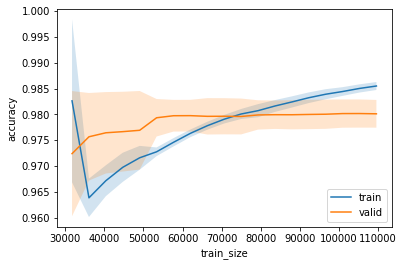

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

для алгоритма классификации на опорных векторах увеличение количества сессий более 80 000 в обучающей выборке не дает роста доли правильных ответов.

## выводы:

Реализованный в рамках финального курса специализации проект, систематизирует и позволяет оценить на практике методы анализа данных, освоенных в рамках курсов специализации.

Задача идентификации пользователей представляет практический интерес и реализуется с различным успехом теми или иными компаниями. Решение, предложенное в финальном курсе предполагает обширную область для исследования и содержит в себе решение следующих вопросов:

* Поиск признаков. Объектом классификации является пользовательская сессия выявление признаков, характеризующих пользовательскую сессию является важной задачей подготовки данных. Помимо списка идентификаторов сайтов, из которых состоит сессия, сильное влияние на результат оказывают временные параметры сессиии: продолжительность, время суток начала сессии, день недели и др. Дополнительно встает вопрос определения сессии: какой размер окна, количество посещенных сайтов в сессии. Вклад каждого признака можно попытаться оценить, используя классификаторы с L1 регуляризацей, которые помогут отобрать наиболее важные признаки. Дополнительно имеет смысл сделать визуализацию объектов в пространстве пониженной размерности и проанализировать образуют ли сессии отдельных пользователей кластеры.

* Вторым шагом является выбор алгоритма классификации и подбор оптимальных параметров для выбранного алгоритма. Из результатов проведенного анализа лучшую долю верных ответов дают линейные алгоритмы: классификатор на опорных векторах и логистическая регрессия. Использование многоклассовая классификация (10 пользователей) дает невысокую долю правильных ответов: ~0.87 для сессий, состоящих из 15 сайтов и шириной окна 5. По мере увеличения количества пользователей качество многоклассовой классификации снижается, что подтверждают результаты анализа сессий 400 пользователей. Бинарная классификация (идентификация) какого-то одного пользователя даёт высокую долю правильных ответов и в 81% случаев эта доля выше константных предсказаний (ширина окна 10, сессия из 10 сайтов). Дополнительно имеет смысл проанализировать результаты, которые дают композиции линейных алгоримтов и бустинга.

* Размер обучающей выборки влияет на долю правильных ответов на тестовой выборке до определенного порога. После превышения этого порога, доля правильных ответов на тестовой выборке фиксируется на определенном уровне, что позволяет определить достаточный размер обучающей выборки.